#A Quick Intro to Sampling Theory 

In [3]:
# Boilerplate environment setup
%pylab inline
pylab.rcParams["figure.figsize"] = (14,3)

Populating the interactive namespace from numpy and matplotlib


Let's start with some quick fundamentals about how radio signals are represented in the computer and a few gotchas associated with those representations.

In the real world, signals are continuous waves: they have infinite resolution, so you can zoom in closer and closer, and see more and more detail.  Unfortunately, digital computers aren't continuous devices: they work with discrete samples of the images, taken with some time step.  Every sample consumes some memory, so getting a fully continuous waveform would require infinite memory(!).  Outside of a Turing Machine, this isn't available to us, so we sample the data on some clock ticks.

The time between those clock ticks is the sample step; the frequency of those ticks (how many there are per second) is the sample rate.

To explain this better, we'll "simulate" the problem, by having a waveform generated at a very high sample rate, and then sample it at a lower sample rate.

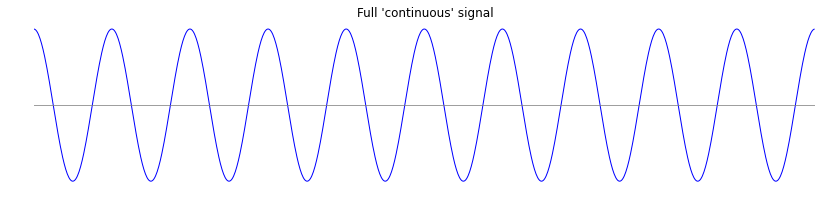

In [4]:
sample_step = 0.001  # 1 ms
Fs = 1.0/sample_step # Sample rate

Fc = 10.0            # 10 Hz "carrier" signal

# Generate the points in time for our "continuous" signal
time_steps = np.arange(0,1, sample_step) # from 0 to 1 seconds

# Generate the "continuous" signal
real_signal = np.cos(time_steps * (2*np.pi) * Fc)

plot(real_signal, label="Full signal")
title("Full 'continuous' signal")

# Make things prettier
ylim(-1.1, 1.1)
axis('off')
axhline(0, color="grey", alpha=0.75)
None

Now, we need to sample the continuous waveform to get down to digital samples in the computer.  Let's sample at 4ms between samples, or 250Hz.  This is 1/4 the sample rate of our original signal, so we just take every fourth entry.

We'll plot our new "digital sample" version of the "continuous" waveform with dots, to emphasize the fact that it's exclusively digital.

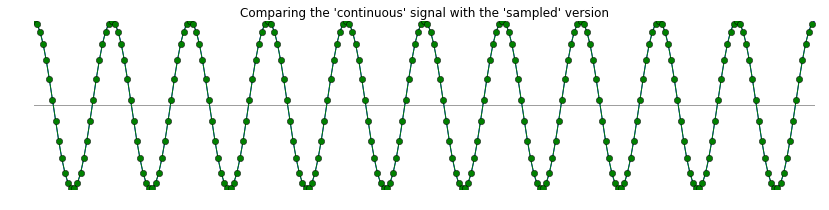

In [5]:
capture_times = time_steps[0:-1:4]
capture_samples = real_signal[0:-1:4]

title("Comparing the 'continuous' signal with the 'sampled' version")

# Make it pretty
axis('off')
axhline(0, color="grey", alpha=0.75)

plot(time_steps, real_signal)
plot(capture_times, capture_samples, 'o-')
None

As you can see, our new sampled version of the signal looks pretty good.  It's not as clean as the original signal was, but it's still a reasonable facsimile.

Now, let's think about this a bit: our "continuous" waveform was actually just a digital capture with a relatively high sample rate.  Our "sampled" one, which looks an awful lot like the original waveform, is just skipping over 3 out of every 4 samples. It seems like we can do an okay job capturing the same signal with a quarter the memory usage.  Looking at the figure, going down to 1/5 will also yield an okay-looking waveform.  So will 1/6... it's clear that there's room to reduce the sample rate without losing the essence of our 10Hz signal.

Obviously, there's a lower bound to how much we can "decimate" the signal: we could give a single data point, "0", since that's the average of this whole waveform, but that leaves out a bit of the nuance of the overall signal.  How far can we push this?  Let's see what we get with different divisors.

In [10]:
def plot_downsample(n):
    "Plot our signal, downsampled to 1 sample every *n* samples"
    capture_times = time_steps[0:-1:n]
    capture_samples = real_signal[0:-1:n]

    plot(time_steps, real_signal)
    plot(capture_times, capture_samples, '-o', linewidth=2)
    ylim(-1.1,1.1)
    title("Downsample by %d" % n)
    axis('off')
    axhline(0, color="grey", alpha=0.75)
    

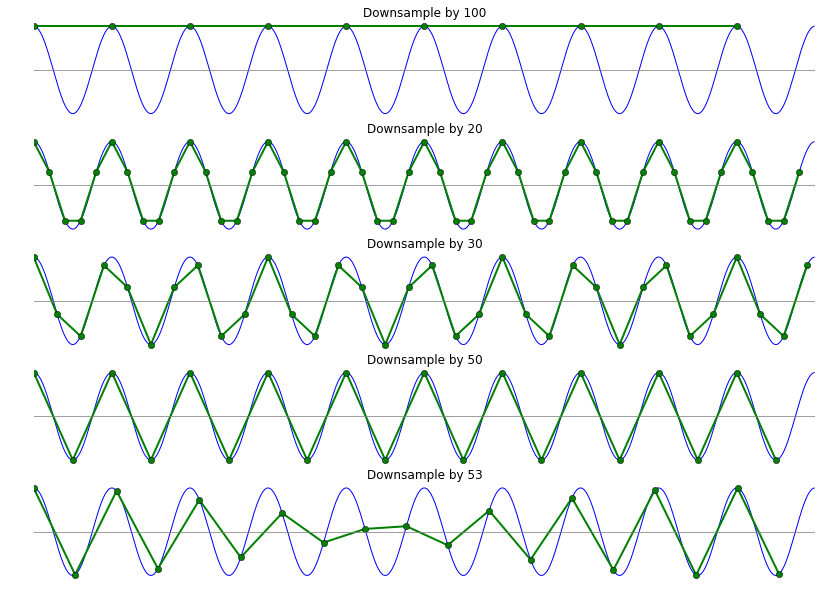

In [11]:
decimations = [ 100, 20, 30, 50, 53 ]
figure(figsize(14,10))

for i,decimation in enumerate(decimations):
    subplot(len(decimations), 1, i+1)
    plot_downsample(decimation)


Downsampling by 100x clearly doesn't work: we only capture the peaks.  20x looks okay-ish, as does 30x.  50x downsampling gives us the peaks and the troughs, which is the fundamental essence of the signal.  Anything over 50x and we lose the shape of our waveform.  Downsampling by 53x results in something that's kind of almost our signal, but its amplitude varies over time, which is no good.

Note that our input sample rate was 1000Hz, and that decimating is the same as dividing the sample rate.  So, when we downsampled by 20x, our 1000Hz sample rate turned into a 1000/20 = 50Hz downsampled sample rate.  Similarly, 30x results in 33.33Hz, and 50x gives 20Hz.

Our input signal was at 10Hz, which means that it goes up and comes back down 10 times per second.  If we want to capture the up _and_ the down, we need a sample rate that's at least double that, or 20Hz.  If we spread out our sample points any further, we lose the essential "up-down-ness" of the signal, and therefore lose the signal.

This leads us to a fundamental result in sampling theory: the *Nyquist Limit*.  To capture a signal of a given frequency, you must use a sample rate that's at least twice the frequency of interest.  However, you're usually better off "oversampling" even further, as we'll show now.

Let's sample right at our Nyquist limit, or 20Hz.  What if we hadn't started at exactly the top of the signal?  What if we'd started out at a random point in the waveform, and sampled at exactly the Nyquist frequency?

In [14]:
def plot_downsample(n, offset=0):
    "Decimate the original 'continuous' signal by *n*, starting at sample *offset*"
    
    title("Downsample by %d, offset=%d" % (n,offset))
    
    capture_times = time_steps[offset:-1:n]
    capture_samples = real_signal[offset:-1:n]
    
    
    plot(time_steps, real_signal)
    plot(capture_times, capture_samples, '-o', linewidth=2)

    # Make it pretty
    ylim(-1.1,1.1)
    axis('off')
    axhline(0, color="grey", alpha=0.75)
    

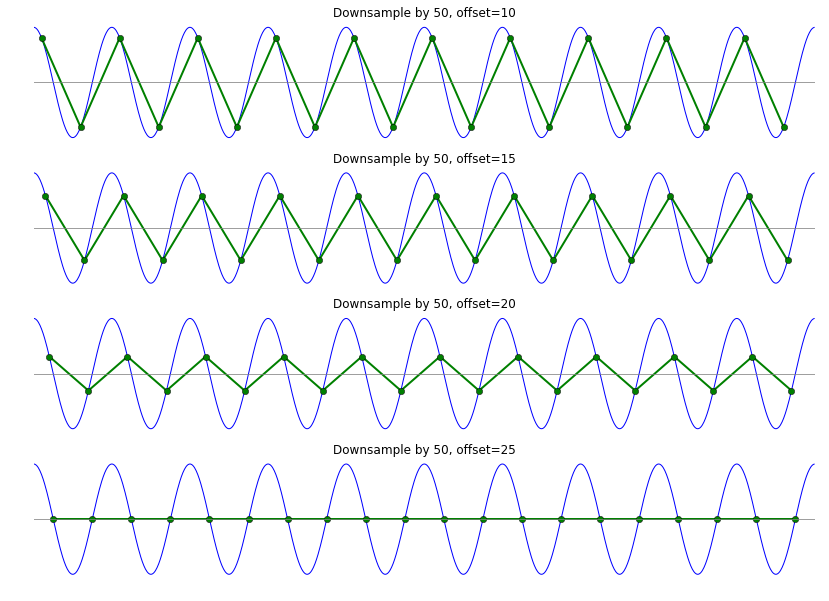

In [15]:
offsets = [10, 15, 20, 25]

figure(figsize=(14,10))

for i, offset in enumerate(offsets):
    subplot(len(offsets), 1, i+1)
    plot_downsample(50, offset)

As the offset moves right, the amplitude of the downsampled signal gets smaller and smaller.  Even though we're theoretically okay to sample at this rate, we find that, in practice, it can be dangerous.  For this reason, I tend to try and oversample by 4x (ie double the Nyquist frequency) whenever possible.

## Stupid Sinusoid Tricks

We generated the waveform above with a cosine signal, which is all about going around a circle, right?  When we take $\cos(\theta$), it's telling us about the $x$-axis component of a triangle of angle $\theta$: 

(-1.1, 1.1)

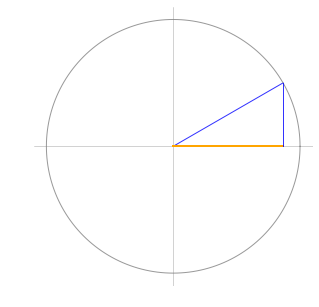

In [98]:
figure(figsize=(5,5))
axhline(0, color="grey", alpha=0.7, linewidth=0.5)
axvline(0, color="grey", alpha=0.7, linewidth=0.5)

theta = 30.0 * (np.pi/180.0) # radians, not degrees
x,y = (np.cos(theta), np.sin(theta))
plot([0,x],[0,y], color="blue", alpha=0.8)

circle_pts = np.arange(0, 2*np.pi+np.pi/100, np.pi/100)
plot(np.cos(circle_pts), np.sin(circle_pts), alpha=0.8, color="grey")

plot([0,x],[0,0], linewidth=2, color="orange")
plot([x,x],[0,y], linewidth=1, color="blue", alpha=0.8)

axis("off")
xlim(-1.1,1.1)
ylim(-1.1,1.1)


As we sweep the angle $\theta$ around, the size of the $x$ component of this triangle will vary as a sinusoidal wave.  This is what we're actually seeing in the cosine wave above.

#The Frequency Domain vs The Time Domain 

If you look back, we said that the amount of memory it takes to store a signal is related to how often you sample that signal.  We then went on to demonstrate this, generated many thousands of bytes of data for the signal.

The data we generated shows the amplitude of the waveform over time: the y axis is how strong the signal is, and the x-axis is time.  This representation of the signal takes far more than three small pieces of data to capture the wave.

You may have noticed that we did this with less than several thousand bytes of code: there's clearly a better way to represent this trivial signal than we let on!  We needed to know that there was a cosine signal of 10Hz of amplitude=1, over the time span 0~1s.  With those three pieces of information, you can reconstruct the waveform as shown.

Going from the frequency domain to the time domain is pretty straightforward: we just run cosine with the appropriate arguments.  How do we go from the time domain to the frequency domain?  That is: how do we take a given signal and decompose it into a bunch of cosines?  The answer to this is the Fourier transform.  The details of it are a bit math-y, and I don't want to go into them just yet.  So, for now, we're going to use it without fully understanding how to derive it.